# Variation due to `word2vec`'s random initialisation

 - fairly small at the word analogy task

In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from itertools import chain
from notebooks.common_imports import *
from gui.output_utils import *
from gui.user_code import pretty_names
sns.timeseries.algo.bootstrap = my_bootstrap
sns.categorical.bootstrap = my_bootstrap

/Users/miroslavbatchkarov/NetBeansProjects/ExpLosion


In [6]:
def get(corpus='amazon_grouped-tagged', rep=0, avg=False, reorder=False,
       composers=['Add', 'Mult', 'Left', 'Right']):
    query_dict = {
        'expansions__use_similarity': 0, 
          'expansions__neighbour_strategy':'linear',
          'expansions__vectors__dimensionality': 100, 
          'document_features_ev': 'AN+NN', 
          'document_features_tr': 'J+N+AN+NN', 
          'expansions__allow_overlap': False,
          'expansions__entries_of': None,
          'expansions__vectors__algorithm': 'word2vec',
          'expansions__vectors__composer__in': composers, 
          'expansions__vectors__unlabelled': 'wiki',
          'expansions__decode_handler': 'SignifiedOnlyFeatureHandler',
          'expansions__noise': 0,
          'expansions__use_similarity': 0, 
          'expansions__k':3,
          'expansions__vectors__unlabelled_percentage': 15,
          'expansions__vectors__rep': rep,
          'expansions__vectors__avg': avg,
          'expansions__vectors__reorder': reorder,
          'labelled':corpus}
    return [foo.id for foo in Experiment.objects.filter(**query_dict)]

[75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86]
Calculating CI for exp 79
Calculating CI for exp 80
Calculating CI for exp 81
Calculating CI for exp 82
Calculating CI for exp 83
Calculating CI for exp 84
Calculating CI for exp 85
Calculating CI for exp 86
Composer has 6000 values
folds has 6000 values
rep has 6000 values
Accuracy has 6000 values


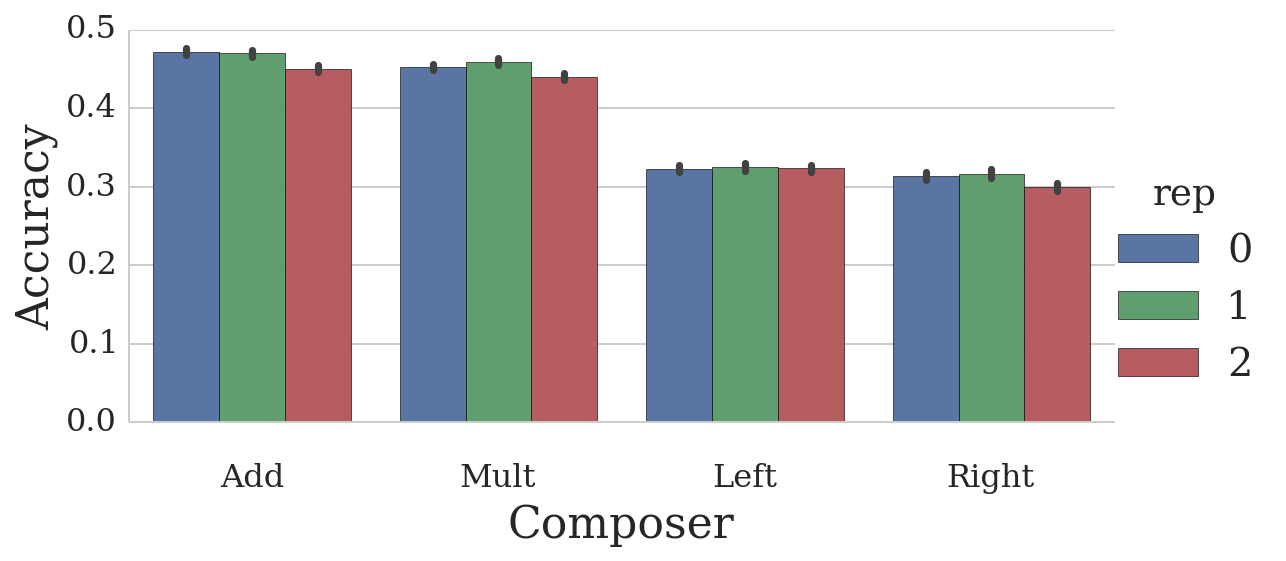

In [3]:
ids = list(chain.from_iterable(get(rep=r) for r in [0, 1, 2]))
print(ids)
df = dataframe_from_exp_ids(ids, fields_to_include={'rep':'expansions__vectors__rep',
                                                    'Composer': 'expansions__vectors__composer'})
sns.factorplot(data=df, x='Composer', y='Accuracy', hue='rep', 
               hue_order='0 1 2'.split(), 
               kind='bar', ci=68, aspect=2);
plt.savefig('plot-w2v_random_init_var.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# Are the differences significant? 

In [15]:
ids = list(chain.from_iterable(get(rep=r, composers=['Add']) for r in [0, 1, 2]))
ids

[75, 79, 83]

In [16]:
sign_df, _, _ = get_demsar_params(ids, ['expansions__vectors__rep'])
sign_df

,name1,acc1,name2,acc2,mean_diff,pval,significant
0,0,0.471414,1,0.469746,0.001668,0.792,False
1,0,0.471414,2,0.450353,0.021061,0.002,True
2,1,0.469746,2,0.450353,0.019393,0.000,True


[75, 76, 77, 78, 71, 72, 73, 74, 296, 300, 302, 304, 297, 301, 303, 305, 298, 299]
Calculating CI for exp 71
Calculating CI for exp 72
Calculating CI for exp 73
Calculating CI for exp 74
Calculating CI for exp 296
Calculating CI for exp 300
Calculating CI for exp 302
Calculating CI for exp 304
Calculating CI for exp 297
Calculating CI for exp 301
Calculating CI for exp 303
Calculating CI for exp 305
No results for query {'classifier': 'MultinomialNB', 'id': 298}
No results for query {'classifier': 'MultinomialNB', 'id': 299}
Composer has 9000 values
avg has 9000 values
dice has 9000 values
rep has 9000 values
folds has 9000 values
Accuracy has 9000 values


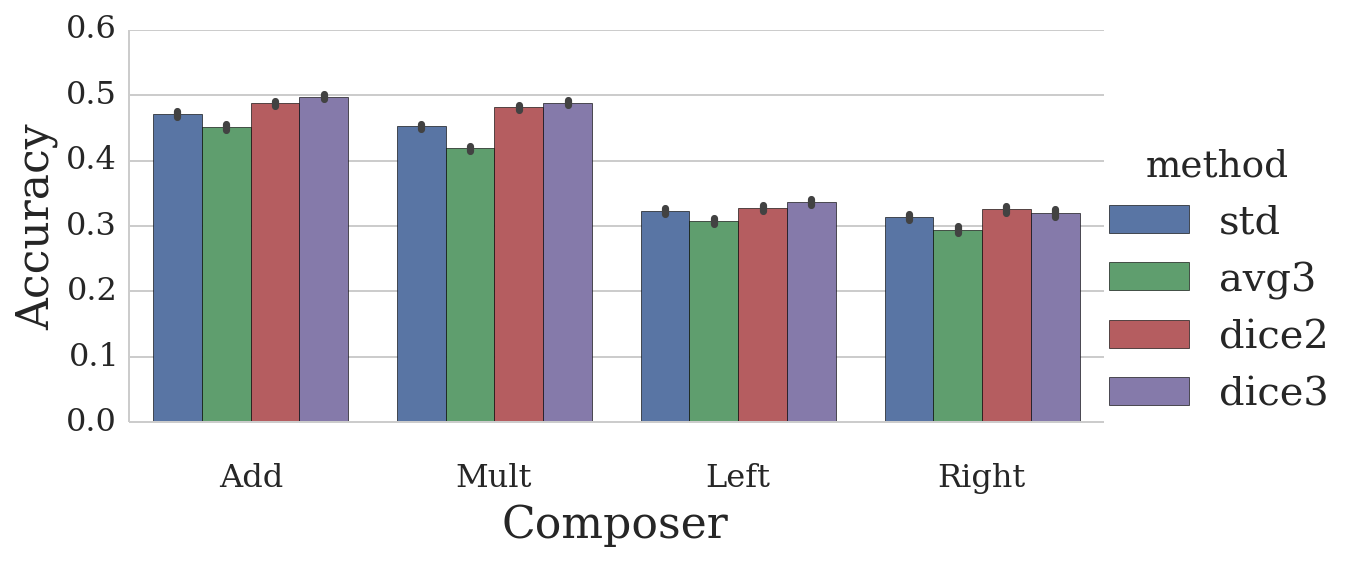

In [4]:
ids = get(rep=0) + get(rep=3, avg=True) + list(chain.from_iterable(get(rep=i, reorder=True) for i in [2,3,4,5]))
print(ids)
df = dataframe_from_exp_ids(ids, fields_to_include={'rep':'expansions__vectors__rep',
                                                    'avg':'expansions__vectors__avg',
                                                    'dice':'expansions__vectors__reorder',
                                                    'Composer': 'expansions__vectors__composer'}).convert_objects(convert_numeric=True)

df['method'] = 'avg3'
df.loc[df.rep==0, 'method'] = 'std'
for i in [2,3,4,5]:
    df.loc[(df.rep==i) & (df.dice==1), 'method'] = 'dice%d'%i
df = df.drop('avg dice rep'.split(), axis=1)
sns.factorplot(data=df, x='Composer', y='Accuracy', hue='method', 
               kind='bar', ci=68, aspect=2);
plt.savefig('plot-w2v_random_init_boost.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# Are the differences significant?

In [10]:
comp = ['Add', 'Mult']
ids = get(rep=0, composers=comp) + get(rep=3, reorder=True, composers=comp)
ids

[75, 76, 297, 301]

In [13]:
sign_df, _, _ = get_demsar_params(ids, ['expansions__vectors__composer', 
                        'expansions__vectors__reorder'])
sign_df

,name1,acc1,name2,acc2,mean_diff,pval,significant
0,Add-0,0.471414,Mult-0,0.452228,0.019186,0.000,True
1,Add-0,0.471414,Add-1,0.497166,0.025752,0.000,True
2,Add-0,0.471414,Mult-1,0.488409,0.016995,0.004,True
3,Mult-0,0.452228,Add-1,0.497166,0.044938,0.000,True
4,Mult-0,0.452228,Mult-1,0.488409,0.036182,0.000,True
5,Add-1,0.497166,Mult-1,0.488409,0.008756,0.122,False


# Compare unigram vectors between multiple runs
How many of the top `n` neighbour of some entries are the same accross multiple runs

In [25]:
from glob import glob
from discoutils.thesaurus_loader import Vectors as V
from random import sample
from itertools import combinations

pattern = '/lustre/scratch/inf/mmb28/FeatureExtractionToolkit/word2vec_vectors/word2vec-wiki-15perc.unigr.strings.rep*'
files = sorted(glob(pattern))
thes = [V.from_tsv(f) for f in files]
for t in thes:
    t.init_sims(n_neighbors=100)

In [26]:
def dice(n1, n2):
    return 2 * len(set(n1) & set(n2))/ (len(n1) + len(n2))


def dice_loop(words, thes, log=False):
    dice_data = []
    for i,j in combinations(range(len(thes)), 2):
        pair_id = '%d-%r'%(i,j if j < 3 else 'A')
        if log:
            print('Doing pair', pair_id, flush=True)
        for num, word in enumerate(words):
            n1 = [x[0] for x in thes[i].get_nearest_neighbours(word)]
            n2 = [x[0] for x in thes[j].get_nearest_neighbours(word)]
            if n1 and n2:
                dice_data.append([pair_id, word, dice(n1, n2)])
    return dice_data

In [22]:
sampled_words = sample(list(thes[0].keys()), 5000)
dice_data = dice_loop(sampled_words, thes, log=True)

Doing pair 0-1
Doing pair 0-2
Doing pair 1-2


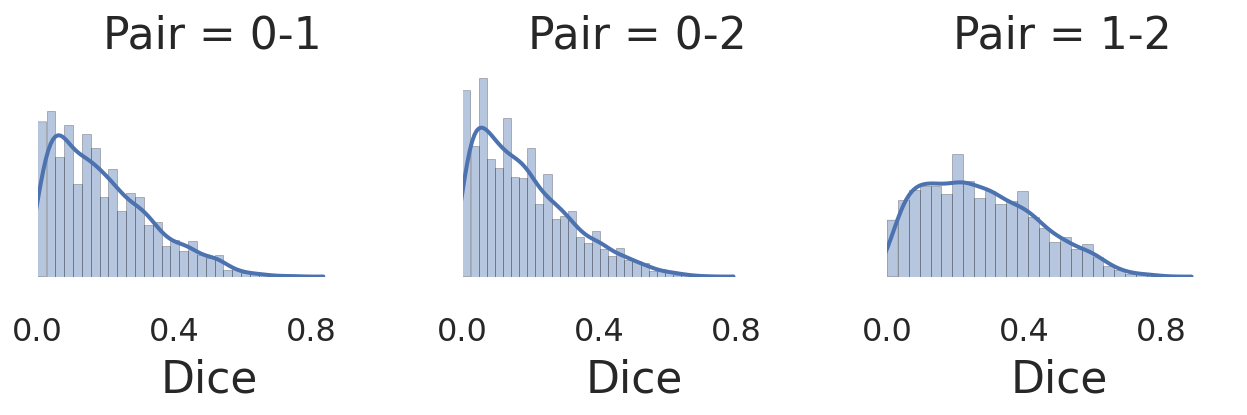

In [23]:
df3 = pd.DataFrame(dice_data, columns='Pair Word Dice'.split())
with sns.axes_style("white"):
    g = sns.FacetGrid(df3, col="Pair", col_wrap=3);
    g.map(sns.distplot, 'Dice', kde=True);

for ax in g.axes.flat:
    sparsify_axis_labels(ax)
    ax.set_xlim(0, 1.01)
    ax.set_yticklabels([])

sns.despine(left=True, bottom=True)
plt.savefig('plot-w2v_random_init_neigh_overlap.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# Observations
Neighbours tend to be quite different over multiple runs, but the overall accuracy of the classification task changes very little
# Qualitative analysis
See below
Seems to me good neighbours (which seem sensible) tend to be the same across repeated runs

In [27]:
def multiway_dice(entry, thesauri):
    df = pd.DataFrame(dice_loop([entry], thesauri), columns='Pair Word Dice'.split())
    return df.Dice.mean()

In [33]:
df = compare_neighbours(thes, [0, 1, 2, 4, 5],
                        words=['balkans/N', 'lesbian/J', 'ottawa/N', 'sneaker/N', 'essay/N', 'falsify/V', 'inborn/J'])
df['mw_dice'] = [multiway_dice(feat, thes) for feat in df.index]
df.to_csv('compare_repeated_w2v.csv')
df.sort('mw_dice')

,0,1,2,4,5,mw_dice
inborn/J,"demonstrable/J, neuropsychological/J, contrain...","posturing/N, physiologically/RB, self-percepti...","pernicious/J, nonverbal/J, uncomplicated/J, un...","internalization/N, generalised/J, flecainide/N...","psychopathy/N, paraphilia/N, internalization/N...",0.115
balkans/N,"transoxiana/N, dagestan/N, arakan/N, ostsiedlu...","cisalpine/N, interbellum/N, south-eastern/N, b...","transcaucasia/N, dodecanese/N, carpathians/UNK...","transcaucasia/N, rumelia/N, makran/N, ingria/N","dodecanese/N, bashkortostan/N, north-eastern/N...",0.176
sneaker/N,"overalls/N, pinstripe/N, sleeveless/J, necktie/N","sweatshirt/N, headband/N, chiffon/N, overalls/N","bandana/N, stiletto/N, dreadlock/N, kimono/N","sweatshirt/N, necktie/N, tights/N, leggings/N","see-through/J, kimono/N, tattered/J, pajamas/N",0.296
falsify/V,"substantiate/V, cross-examine/V, reexamine/V, ...","false/J, adduce/V, malfeasance/N, substantiate/V","rebut/V, misrepresent/V, willfully/RB, groundl...","falsified/J, adduce/V, mislead/V, retry/V","falsification/N, falsified/J, misrepresent/V, ...",0.357
ottawa/N,"montreal/N, winnipeg/N, catharines/N, toronto/N","catharines/N, oshawa/N, winnipeg/N, quebec/N","toronto/N, montreal/N, catharines/N, winnipeg/N","montreal/N, toronto/N, calgary/N, saskatoon/N","mississauga/N, toronto/N, guelph/N, winnipeg/N",0.368
lesbian/J,"gay/J, lesbian/N, transgender/J, transgendered/J","gay/J, transgender/J, bisexual/J, lgbt/N","gay/J, bisexual/J, transgender/J, lesbian/N","gay/J, transgender/J, bisexual/J, transsexual/J","gay/J, bisexual/J, lesbian/N, transgender/J",0.485
essay/N,"pamphlet/N, monograph/N, poem/N, treatise/N","book/N, pamphlet/N, monograph/N, two-volume/J","book/N, pamphlet/N, poem/N, monograph/N","book/N, monograph/N, pamphlet/N, poem/N","monograph/N, pamphlet/N, book/N, poem/N",0.650


In [34]:
print(pd.DataFrame(df.stack()).to_latex())

\begin{tabular}{lll}
\toprule
          &   &                                                  0 \\
\midrule
balkans/N & 0 &  transoxiana/N, dagestan/N, arakan/N, ostsiedlu... \\
          & 1 &  cisalpine/N, interbellum/N, south-eastern/N, b... \\
          & 2 &  transcaucasia/N, dodecanese/N, carpathians/UNK... \\
          & 4 &     transcaucasia/N, rumelia/N, makran/N, ingria/N \\
          & 5 &  dodecanese/N, bashkortostan/N, north-eastern/N... \\
          & mw\_dice &                                              0.176 \\
lesbian/J & 0 &   gay/J, lesbian/N, transgender/J, transgendered/J \\
          & 1 &           gay/J, transgender/J, bisexual/J, lgbt/N \\
          & 2 &        gay/J, bisexual/J, transgender/J, lesbian/N \\
          & 4 &    gay/J, transgender/J, bisexual/J, transsexual/J \\
          & 5 &        gay/J, bisexual/J, lesbian/N, transgender/J \\
          & mw\_dice &                                              0.485 \\
ottawa/N & 0 &    montreal/N, winnipe

In [35]:
df = compare_neighbours(thes, [0, 1, 2, 4, 5])
df.head()

,0,1,2,4,5
echolocation/N,"vocalization/N, vocalisation/N, bioluminescenc...","locomotion/N, vocalization/N, lifeform/N, vert...","well-designed/J, oscilloscope/N, anatomic/J, t...","velociraptor/N, mimic/N, baleen/N, trackball/N","multitasking/N, hallucinogen/N, mpt/N, spherom..."
outgassing/N,"vaporization/N, solidification/N, quenching/N,...",None,None,None,None
mezzo-soprano/N,"coloratura/N, contralto/N, countertenor/N, bas...","contralto/N, soprano/N, bass-baritone/N, color...","contralto/N, flautist/N, soprano/N, coloratura/N","contralto/N, bass-baritone/N, harpist/N, count...","contralto/N, bass-baritone/N, countertenor/N, ..."
carnivora/N,"eudicot/N, procellariiformes/N, conspecific/N,...","proteaceae/N, euphorbiaceae/N, ammonite/J, utr...",None,None,None
squire/N,"jorma/N, macrae/N, bostic/N, formby/N","duncan/N, wilkie/N, tyrell/N, berryman/N","donnell/N, monro/N, dashwood/N, underhill/N","frohman/N, binns/N, henshall/N, comerford/N","strutt/N, o'hagan/N, hardcastle/N, hannon/N"


In [47]:
all_feats = set.union(*[set(v.keys()) for v in thes[:3]])
len(all_feats)

83267

In [48]:
from collections import Counter
Counter(sum(f in v for v in thes[:3]) for f in all_feats)

Counter({3: 51579, 1: 18480, 2: 13208})

In [50]:
pattern = '/lustre/scratch/inf/mmb28/FeatureExtractionToolkit/word2vec_vectors/word2vec-wiki-100perc.unigr.strings.rep0'
v_avg = V.from_tsv(pattern)

In [52]:
v_avg.init_sims(n_neighbors=10)
len(v_avg)

226627

In [66]:
new_entries = set(v_avg.keys()) - set(thes[0].keys())
old_entries = set(v_avg.keys()) & set(thes[0].keys())

In [63]:
new_nouns = [x for x in new_entries if x.endswith('/N')]

In [77]:
len(new_entries), len(old_entries), len(new_nouns)

(161314, 65313, 135837)

In [73]:
new_entries

{'jungleland/N',
 'us-hus/N',
 'blithely/RB',
 'font-weight/J',
 'pipelining/N',
 'saka/UNK',
 'nearshore/N',
 'limbe/N',
 'stigmellum/N',
 'hibbard/N',
 'kanta/N',
 'gommendy/N',
 'macedo/N',
 'waymark/N',
 'nadc/N',
 'claypole/N',
 'flagiocathlete/N',
 'limber/J',
 'zarif/N',
 'kenda/N',
 'oshiro/N',
 'pedrosa/N',
 'angreal/N',
 'kilworth/N',
 "anoa'i/N",
 'montfaucon/N',
 'autologous/J',
 'dotson/N',
 'freeskiing/N',
 'wae/N',
 'premaxillary/J',
 'bartkowski/N',
 'de-stalinization/N',
 'prince-bishopric/J',
 'm-g-m/N',
 'marj/N',
 'deporte/N',
 'liberal-conservative/J',
 'luweero/N',
 'privatised/J',
 'arnsberg/N',
 'headboard/N',
 'macfarren/N',
 'gladney/N',
 'slaves/UNK',
 'stepping-stone/N',
 'add-in/N',
 'sizer/N',
 'mitsuki/N',
 'deianeira/N',
 'zerelda/N',
 'lookahead/N',
 'unionised/J',
 'rayment/N',
 'multiphoton/J',
 'zebediah/N',
 'covergirl/N',
 'zululand/N',
 'ktu/N',
 'trinamool/N',
 'klimek/N',
 'hot-button/J',
 'simo/N',
 'jassi/N',
 'azariah/N',
 'risker/N',
 'gryce

In [80]:
v_avg.get_nearest_neighbours('measured/J')

[('extravert/N', 1.2206645427572558),
 ('photoinhibition/N', 1.2268042261113046),
 ('inessential/J', 1.2355771198070054),
 ('spillover/J', 1.255496637360789),
 ('strangelet/N', 1.2661434508282658),
 ('retrogression/N', 1.2728655184461561),
 ('photoionization/N', 1.2739789904460517),
 ('self-recognition/N', 1.2808519646775918),
 ('microphysic/N', 1.2869837189422086),
 ('self-affirmation/N', 1.2886332268324958)]